<a href="https://www.kaggle.com/code/fanbyprinciple/visualizing-text-embeddings?scriptVersionId=126742493" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [31]:
!pip install cohere altair > /dev/null

we will be using something called cohere whiwch is an embedding service. you can get your keys from here: https://dashboard.cohere.ai/api-keys

In [32]:
import cohere
import pandas as pd
import numpy as np
import altair as alt

api_key = {API_KEY}
co = cohere.Client(api_key)


In [33]:
df_orig = pd.read_csv('https://raw.githubusercontent.com/cohere-ai/notebooks/main/notebooks/data/atis_intents_train.csv',names=['intent','query'])

sample_classes = ['atis_airfare', 'atis_airline', 'atis_ground_service']
df = df_orig.sample(frac=0.12, random_state=30)
df = df[df.intent.isin(sample_classes)]
df.reset_index(drop=True, inplace=True)

intents = df['intent']

In [34]:
df.head()

,intent,query
0,atis_airline,which airlines fly from boston to washington ...
1,atis_airline,show me the airlines that fly between toronto...
2,atis_airfare,show me round trip first class tickets from n...
3,atis_airfare,i'd like the lowest fare from denver to pitts...
4,atis_ground_service,show me a list of ground transportation at bo...


we are taking a limited subset of the entire dataset. and dropping the intent column from the df.

In [35]:
df.drop(columns=['intent'], inplace=True)
df.head()


,query
0,which airlines fly from boston to washington ...
1,show me the airlines that fly between toronto...
2,show me round trip first class tickets from n...
3,i'd like the lowest fare from denver to pitts...
4,show me a list of ground transportation at bo...


# what comes to mind when you think of embeddings?

When you hear about large language models (LLM), probably the first thing that comes to mind is the text generation capability, such as writing an essay or creating a marketing copy.

But another thing you can get is text representation: a set of numbers that represent what the text means, and somehow capture the semantics of the text. These numbers are called text embeddings.

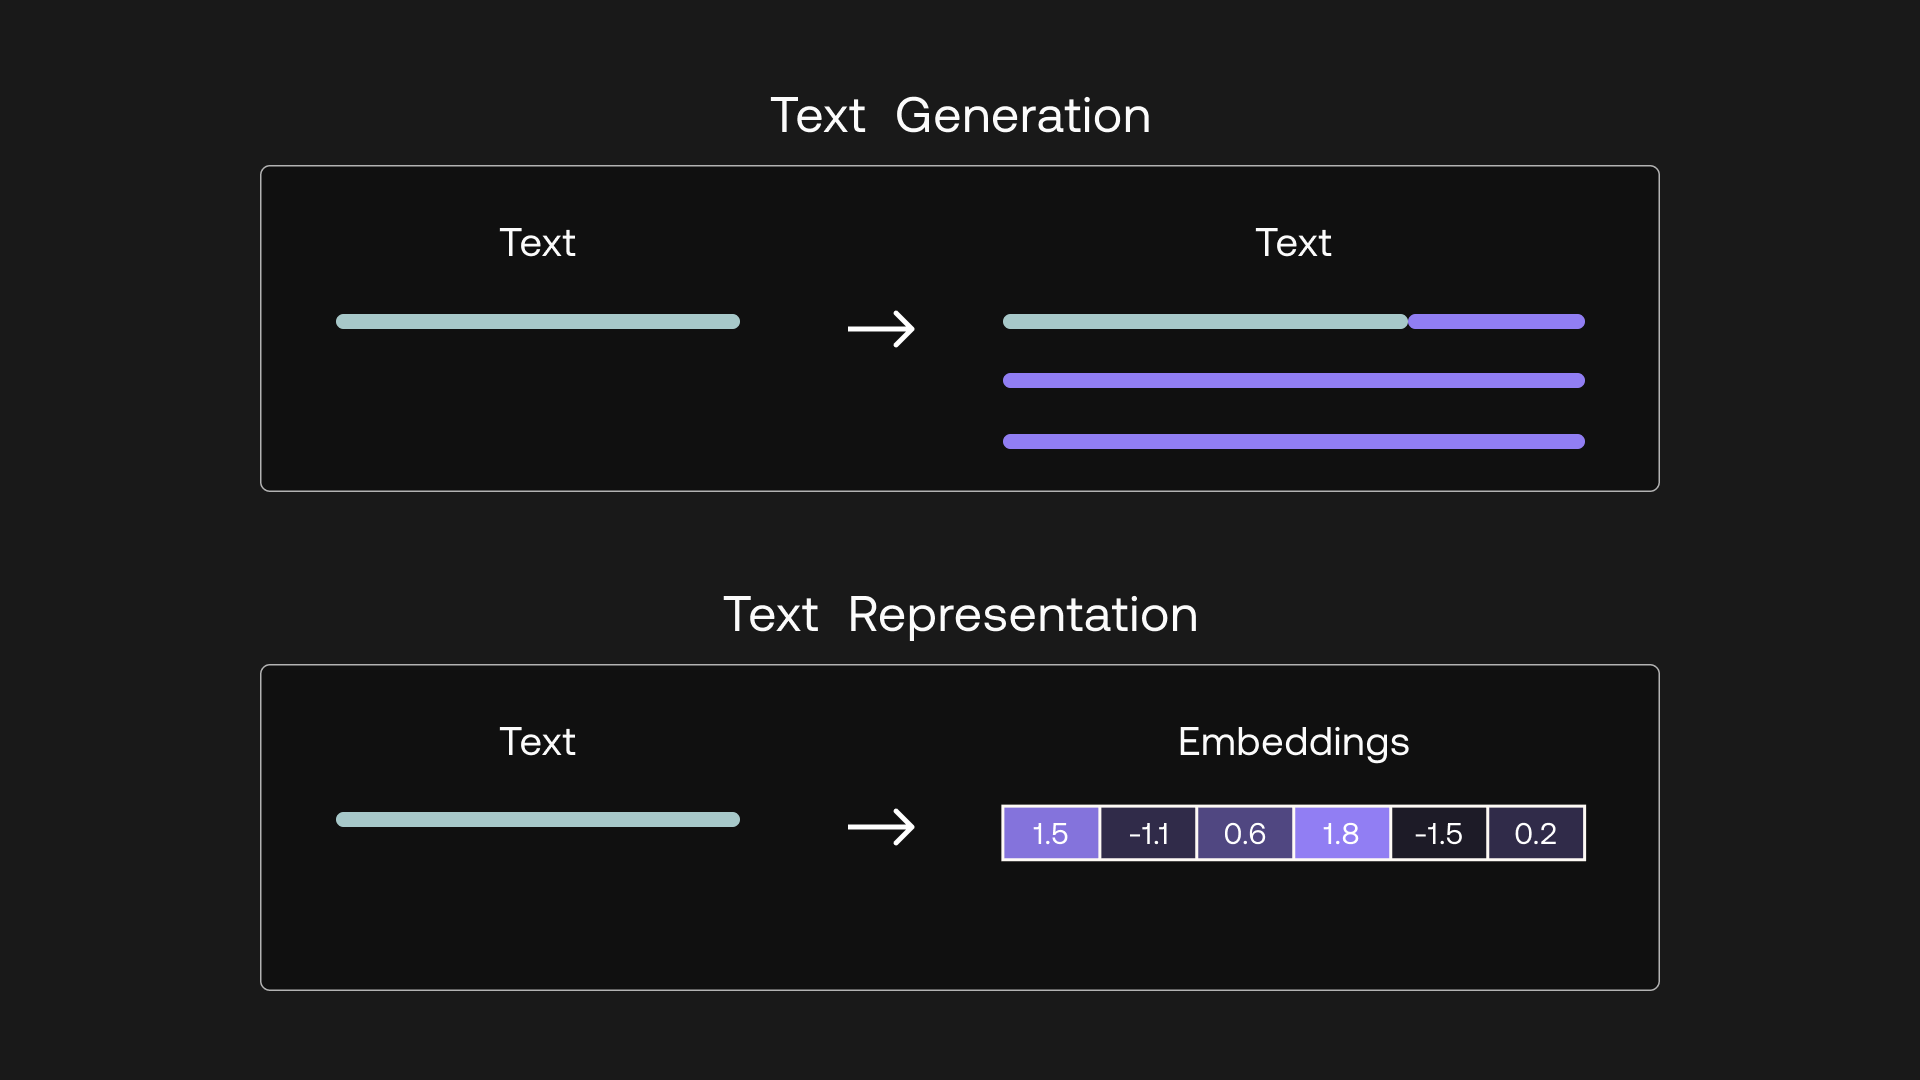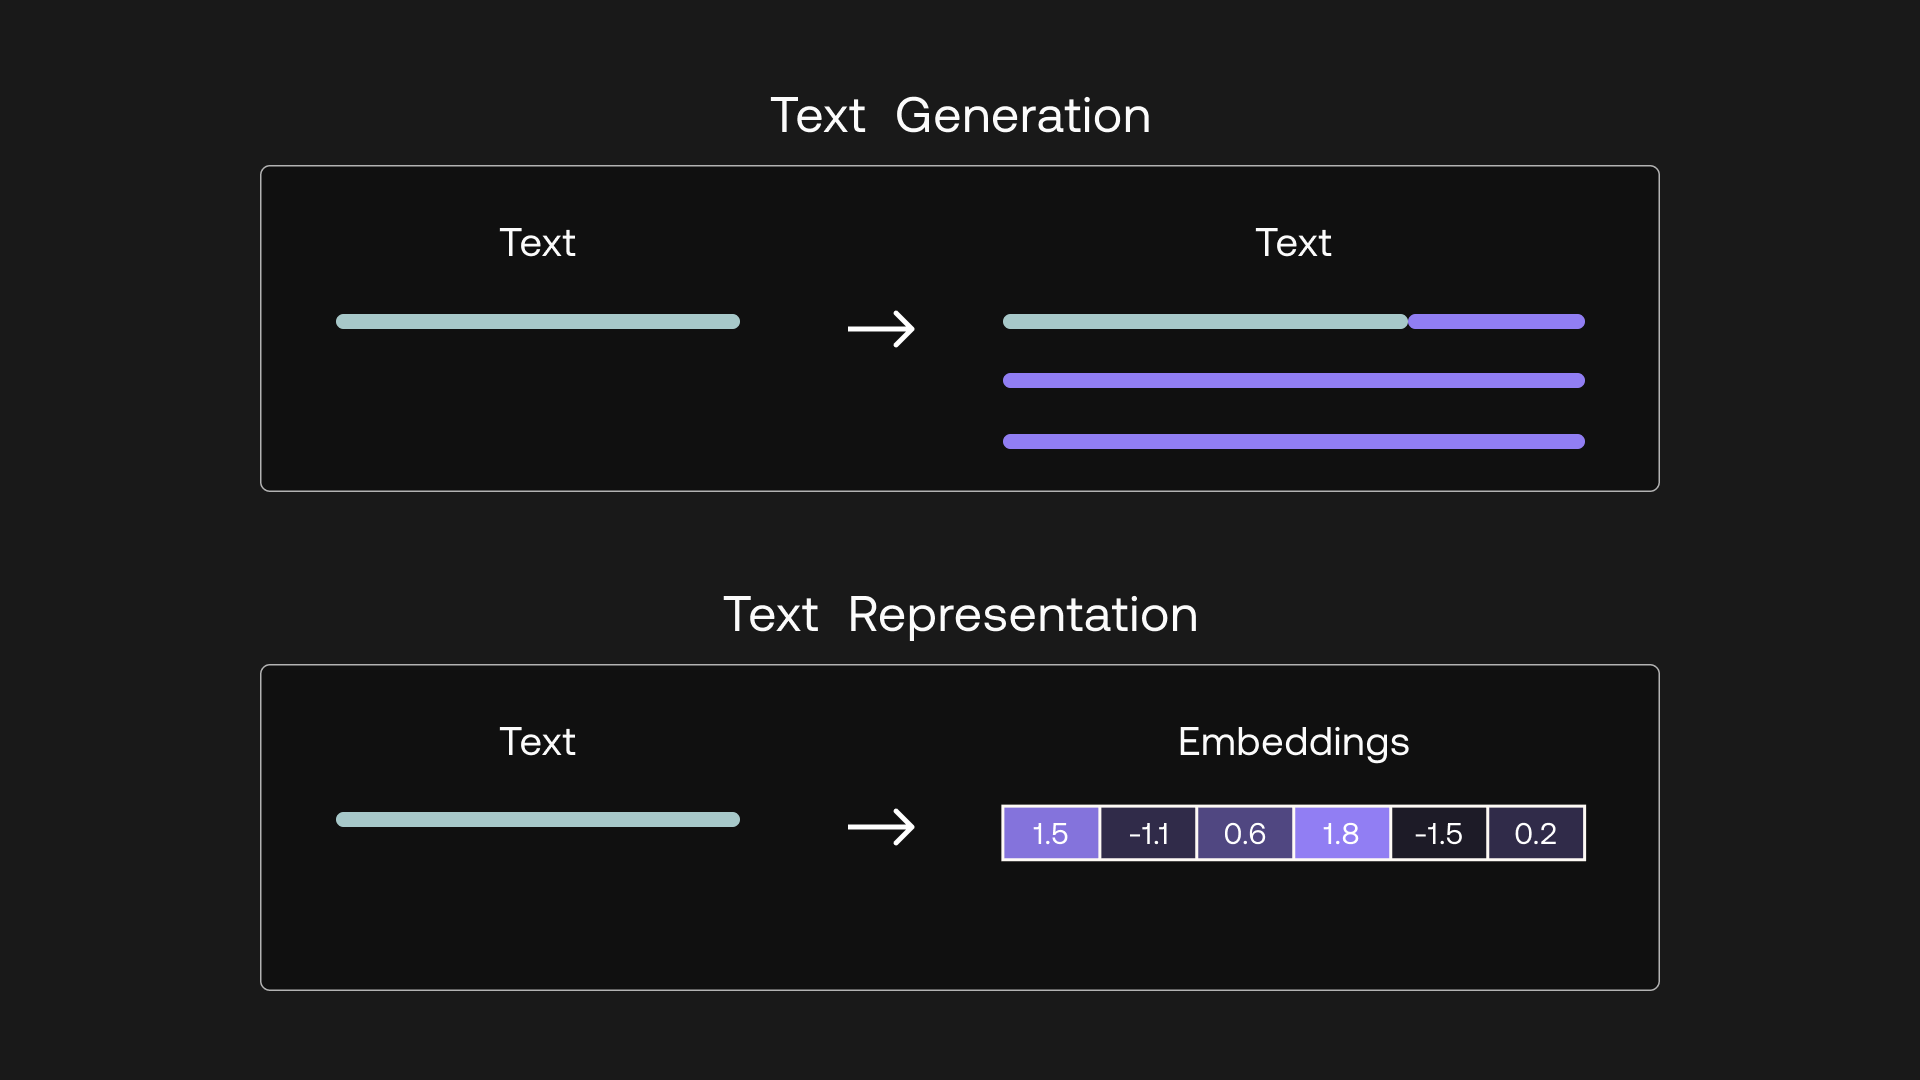

In [36]:
# we can turn text into embeddings?

# Get text embeddings from cohere

def get_embeddings(texts, model='small'):
    output = co.embed(
                model=model,
                texts=texts
    )
    return output.embeddings


In [37]:
# embed the dataset

df['query_embeds'] = get_embeddings(df['query'].tolist())
df.head()

,query,query_embeds
0,which airlines fly from boston to washington ...,"[2.1054688, -0.68847656, -2.421875, -0.1926269..."
1,show me the airlines that fly between toronto...,"[-0.24707031, -0.5263672, 1.3710938, -0.226196..."
2,show me round trip first class tickets from n...,"[-0.31420898, -2.3457031, 0.48779297, -0.77441..."
3,i'd like the lowest fare from denver to pitts...,"[1.2578125, -3.015625, 0.04525757, -0.9379883,..."
4,show me a list of ground transportation at bo...,"[1.1503906, 0.5786133, 0.36645508, -1.65625, 2..."


In [38]:
# look at the dimension of the embedding
len(df['query_embeds'][0])

1024

There are a total of 1024 numbers to represent each individual text, whew! we can visualize these embeddings on a heatmap.

In [39]:
# reduce the dimensionality using PCA
from sklearn.decomposition import PCA

# fucntion to return the principal components
def get_pc(arr, n):
    pca = PCA(n_components=n)
    embeds_transform = pca.fit_transform(arr)
    return embeds_transform

In [40]:
# reducing embeddings to 10 principal components to aid visualisation
embeds = np.array(df['query_embeds'].tolist())
embed_pc = get_pc(embeds, 10)


In [43]:
# Set sample size to visualize
sample = 9

# Reshape the data for visualization purposes
source = pd.DataFrame(embed_pc)[:sample]
source = pd.concat([source,df['query']], axis=1)
source = source.melt(id_vars=['query'])

# Configure the plot
chart = alt.Chart(source).mark_rect().encode(
    x=alt.X('variable:N', title="Embedding"),
    y=alt.Y('query:N', title='',axis=alt.Axis(labelLimit=500)),
    color=alt.Color('value:Q', title="Value", scale=alt.Scale(
                range=["#917EF3", "#000000"]))
)

result = chart.configure(background='#ffffff'
        ).properties(
        width=700,
        height=400,
        title='Embeddings with 10 dimensions'
       ).configure_axis(
      labelFontSize=15,
      titleFontSize=12)

# Show the plot
result

alt.Chart(...)

In [45]:
# visualizing on a 2D plot

# Function to generate the 2D plot
def generate_chart(df,xcol,ycol,lbl='on',color='basic',title=''):
    chart = alt.Chart(df).mark_circle(size=500).encode(
    x=
    alt.X(xcol,
        scale=alt.Scale(zero=False),
        axis=alt.Axis(labels=False, ticks=False, domain=False)
    ),

    y=
    alt.Y(ycol,
        scale=alt.Scale(zero=False),
        axis=alt.Axis(labels=False, ticks=False, domain=False)
    ),
    
    color= alt.value('#333293') if color == 'basic' else color,
    tooltip=['query']
    )

    if lbl == 'on':
        text = chart.mark_text(align='left', baseline='middle',dx=15, size=13,color='black').encode(text='query', color= alt.value('black'))
    else:
        text = chart.mark_text(align='left', baseline='middle',dx=10).encode()

    result = (chart + text).configure(background="#FDF7F0"
        ).properties(
        width=800,
        height=500,
        title=title
       ).configure_legend(
    orient='bottom', titleFontSize=18,labelFontSize=18)
        
    return result


In [46]:
# Reduce embeddings to 2 principal components to aid visualization
embeds_pc2 = get_pc(embeds,2)

# Add the principal components to dataframe
df_pc2 = pd.concat([df, pd.DataFrame(embeds_pc2)], axis=1)

# Plot the 2D embeddings on a chart
df_pc2.columns = df_pc2.columns.astype(str)
generate_chart(df_pc2.iloc[:sample],'0','1',title='2D Embeddings')

alt.LayerChart(...)

Here texts of similar meaning are located close together. We see inquiries about tickets on the left, inquiries about airlines somewhere around the middle, and inquiries about ground transportation on the top right.

# USE CASES

Semantic, or similarity search, that can surface results based on the context or semantic meaning of a query instead of purely keyword-matching.

In [47]:
# Calaculate cosine similarity between the search query and the exisitng ueries

from sklearn.metrics.pairwise import cosine_similarity

def get_similarity(target, candidates):
    candidates = np.array(candidates)
    target = np.expand_dims(np.array(target), axis=0)
    
    #calculate cosine similarity
    sim = cosine_similarity(target, candidates)
    sim = np.squeeze(sim).tolist()
    sort_index = np.argsort(sim)[::-1]
    sort_score = [sim[i] for i in sort_index]
    similarity_scores = zip(sort_index, sort_score)
    
    # return the similarity score
    return similarity_scores


In [49]:
# add new query
new_query = "show business fares"

# get embeddings of the new query
new_query_embeds = get_embeddings([new_query])[0]


In [51]:
# Get the similarity between the search query and exisitng queries
similarity = get_similarity(new_query_embeds, embeds[:sample])

# view the top 5 articles
print('Query:')
print(new_query, '\n')

print('Similar queries:')
for idx,sim in similarity:
    print(f'Similarity: {sim:.2f};',df.iloc[idx]['query'])

Query:
show business fares 

Similar queries:
Similarity: 0.51;  show me round trip first class tickets from new york to miami
Similarity: 0.50;  show me a list of ground transportation at boston airport
Similarity: 0.49;  i'd like the lowest fare from denver to pittsburgh
Similarity: 0.47;  show me boston ground transportation
Similarity: 0.43;  i would like your rates between atlanta and boston on september third
Similarity: 0.41;  show me the airlines that fly between toronto and denver
Similarity: 0.35;  which airlines fly from boston to washington dc via other cities
Similarity: 0.35;  what ground transportation is available in boston
Similarity: 0.33;  of all airlines which airline has the most arrivals in atlanta


The top-ranked FAQ we get is an inquiry about first-class tickets, which is very relevant considering the other options. Notice that it doesn’t contain the keyword “business” and nor does the search query contain the keyword “class”. But their meanings turn out to be the most similar compared to the rest and are captured in their embeddings.